<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Introduction" data-toc-modified-id="1-Introduction-1">1 Introduction</a></span></li><li><span><a href="#2-Data-access" data-toc-modified-id="2-Data-access-2">2 Data access</a></span></li><li><span><a href="#3-Estimate-probabilities" data-toc-modified-id="3-Estimate-probabilities-3">3 Estimate probabilities</a></span></li><li><span><a href="#4-Graphic-analysis" data-toc-modified-id="4-Graphic-analysis-4">4 Graphic analysis</a></span></li><li><span><a href="#5-Define-the-thresholds" data-toc-modified-id="5-Define-the-thresholds-5">5 Define the thresholds</a></span></li></ul></div>

# 1 Introduction
<br>
This notebook defines probability thresholds of each OWT retrieved from the Support Vector Machine Classifier (SVMC) algorithm. It is a pos-processing needed since the SVMC classification will classify any kind of target (e.g. unknown OWT) to a know OWT. Thus, we use the in situ samples with known OWT to define the minimum probability needed to be used in satellite images, and, consequently, discerning between a known OWT and unknown OWT.

# 2 Data access

In [1]:
# library used
import pickle
import pandas as pd
from IPython.core import display as ICD

# read data
msi_svmc_alg = open('00_Database/02_Algorithms/msi_svmc_owts_alldataset.obj', 'rb') 
msi_svmc_alg = pickle.load(msi_svmc_alg)
msi_svmc_shape = msi_svmc_alg[0]
msi_svmc_678 = msi_svmc_alg[1]

insitu_db = pd.read_csv('00_Database/01_Tables/insitu_db.csv', index_col=0)

# define the input data
msi = insitu_db[['B2', 'B3', 'B4', 'B5','B6']]
owts = insitu_db[['OWTs']]
owts_shape = owts.applymap(lambda x: x.replace('OWT 6', 'change').
              replace('OWT 7', 'change').
              replace('OWT 8', 'change').
              replace('change', 'OWT 678'))

In [2]:
msi_svmc_alg

[SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False)]

In [3]:
msi_svmc_alg

[SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False)]

# 3 Estimate probabilities

In [4]:
# define the test ids
test = insitu_db.index

# chooses the algorithm input
msi_norm = msi.divide(msi.sum(axis=1), axis='rows')
msi_b3 = msi[['B3']]

# predict the OWTs in the test dataset (shape)
msi_svmc_predicted = msi_svmc_shape.predict(msi_norm.loc[test,:].values)
msi_svmc_predicted = pd.DataFrame(msi_svmc_predicted,
                                  index=test,
                                  columns=['msi_predicted'])

msi_svmc_predicted_prob = msi_svmc_shape.predict_proba(msi_norm.loc[test,:].values)
msi_svmc_predicted_prob = pd.DataFrame(msi_svmc_predicted_prob, index=test)
msi_svmc_predicted_prob.columns = ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 678']

# predict the OWTs in the test dataset (OWTs 7, 8, and 9)
msi_owt678_predicted_id = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == 'OWT 678'].index
msi_svmc_predicted_678 = msi_svmc_678.predict(msi_b3.loc[msi_owt678_predicted_id,:].values)
msi_svmc_predicted_678 = pd.DataFrame(msi_svmc_predicted_678,
                                      index=msi_owt678_predicted_id,
                                      columns=['msi_predicted'])

msi_svmc_predicted_678_prob = msi_svmc_678.predict_proba(msi_b3.loc[msi_owt678_predicted_id,:].values)
msi_svmc_predicted_678_prob = pd.DataFrame(msi_svmc_predicted_678_prob, index=msi_owt678_predicted_id)
msi_svmc_predicted_678_prob.columns = ['OWT 6', 'OWT 7', 'OWT 8']
msi_svmc_predicted_678_prob = msi_svmc_predicted_678_prob.multiply(msi_svmc_predicted_prob['OWT 678'], axis='rows').dropna()

# concatenate all predicted OWTs
msi_svmc_predicted.update(msi_svmc_predicted_678)
msi_svmc_predicted_prob = msi_svmc_predicted_prob.join(msi_svmc_predicted_678_prob)
msi_svmc_predicted = msi_svmc_predicted.join(msi_svmc_predicted_prob)

In [5]:
msi_svmc_predicted_678_prob

,OWT 6,OWT 7,OWT 8
0,0.004259,0.925542,0.018647
9,0.003931,0.918629,0.018581
10,0.004922,0.964944,0.019093
12,0.004860,0.963727,0.018485
16,0.004101,0.969921,0.019711
...,...,...,...
270,0.008949,0.738912,0.014141
271,0.013482,0.761107,0.015105
272,0.004217,0.960915,0.019548
273,0.003788,0.934030,0.019324


# 4 Graphic analysis

Boxplot


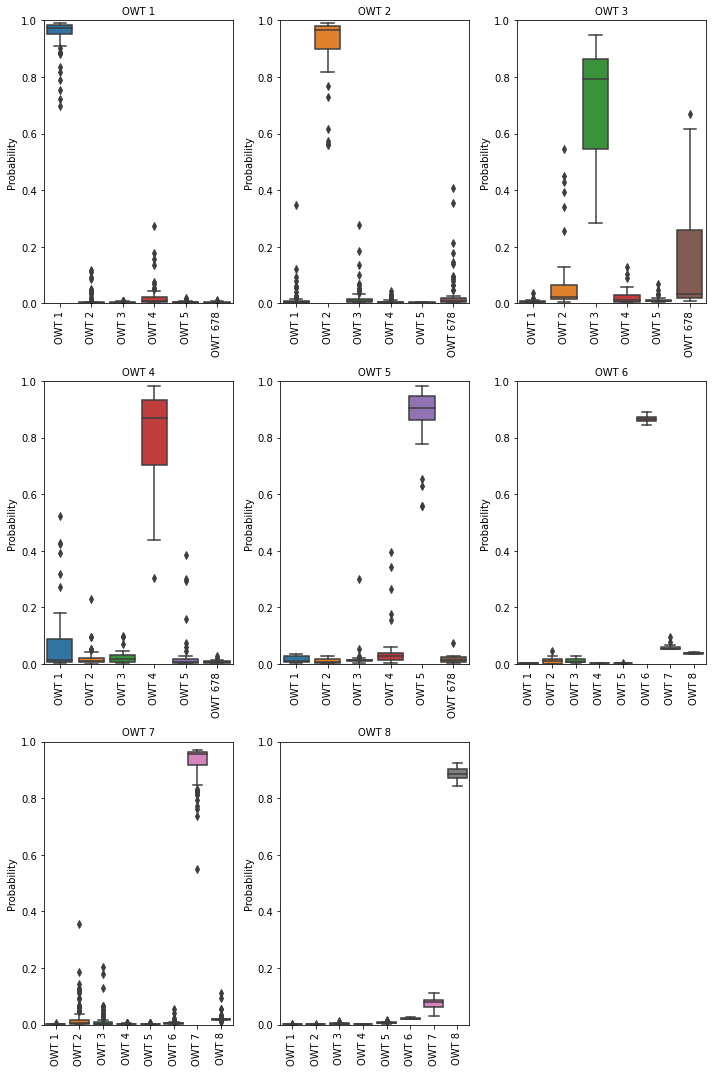

In [6]:
# library used
import seaborn as sns
import matplotlib.pyplot as plt

# plot boxplot
print('Boxplot')
plt.figure(figsize=(10, 15))
i = 1
for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8']:
    
    ax = plt.subplot(3, 3, i)
    subset = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == x]

    if int(x[-1])<6:
        subset = subset.drop(['OWT 6', 'OWT 7', 'OWT 8'], axis=1)
        
    else:
        subset = subset.drop('OWT 678', axis=1)
        
    sns.boxplot(data=subset, ax=ax)
    ax.set_title(x, fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=90)
    
    i=i+1
    
plt.tight_layout()

# 5 Define the thresholds
<br>
The thresholds defined are the minimum values after removing the lower 1%. In other words, the percentile 1% of each distribution.

In [7]:
# library used
import numpy as np

print('Probability thresholds excluding the lowest 1%')
for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8']:
    
    subset = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == x]
    quantitle_5 = np.round(subset.quantile(0.01)[x], 2)
    print(x+' :', quantitle_5)

Probability thresholds excluding the lowest 1%
OWT 1 : 0.72
OWT 2 : 0.56
OWT 3 : 0.3
OWT 4 : 0.35
OWT 5 : 0.56
OWT 6 : 0.85
OWT 7 : 0.74
OWT 8 : 0.84


In [8]:
# library used
import numpy as np

print('Probability thresholds excluding the lowest 5%')
for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4', 'OWT 5', 'OWT 6', 'OWT 7', 'OWT 8']:
    
    subset = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == x]
    quantitle_5 = np.round(subset.quantile(0.05)[x], 2)
    print(x+' :', quantitle_5)

Probability thresholds excluding the lowest 5%
OWT 1 : 0.82
OWT 2 : 0.6
OWT 3 : 0.37
OWT 4 : 0.46
OWT 5 : 0.61
OWT 6 : 0.85
OWT 7 : 0.81
OWT 8 : 0.85
